In [2]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


import geopandas as gpd
from mpl_toolkits.basemap import Basemap as Basemap


import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [4]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [5]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    #flu surveillance data
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [6]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
pd.__version__

'1.4.4'

Pull surveillance data

In [7]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-04-27,02,Alaska,3,0.421688
1,2,2024-04-27,01,Alabama,16,0.315970
2,3,2024-04-27,05,Arkansas,30,0.986233
3,4,2024-04-27,04,Arizona,106,1.443941
4,5,2024-04-27,06,California,151,0.388309
...,...,...,...,...,...,...
6143,6144,2022-02-12,50,Vermont,0,0.000000
6144,6145,2022-02-12,53,Washington,8,0.103415
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6146,6147,2022-02-12,54,West Virginia,5,0.281694


In [8]:
# save surveillance data
observations.to_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq", index=False)

Pull Flu Scenario Modeling Hub data for all models

In [8]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel','MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
          'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha','UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4

for model in models:
    predictions = pull_flu_scenario_modeling_hub_predictions(model,dates)
    predictions['Model'] = model
    
    predictions = predictions[predictions['target'] =='inc hosp']


    numweeks = list(predictions.horizon.unique())

    start_date = list(predictions.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    df = predictions.merge(dfdates, how='inner', on='horizon')


    df.to_parquet(f'../fludat/{model}_rd{rd}.pq', index=False)
    
    

In [ ]:
# save into one dataframe

In [9]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


In [10]:
predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    print(model, len(df.location.unique())) 
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


remove models with only one location

In [11]:
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

predictionsall = predictionsall[~predictionsall['Model'].isin(singleloc_models)]

In [12]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

In [50]:
predictions_traj.target_end_date.max()

Timestamp('2024-04-27 00:00:00')

# Calculate scores

Calculate energy score for each model, scenario, and location

In [17]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

energyscoresdf = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in predictions_traj.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [18]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,426.430823,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,410.700957,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,410.799822,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,408.848089,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,421.623785,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,25598.171912,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,27081.777290,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,25498.213156,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,24345.522962,hosp,US,US,328728466


In [19]:
energyscoresdf.to_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")

calculate normalized energy score for each model, scenario, and location

In [20]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

energyscoresdf_norm = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in predictions_traj.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = normalized_energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf_norm = pd.concat([energyscoresdf_norm, newrow])

energyscoresdf_norm = energyscoresdf_norm.reset_index()
energyscoresdf_norm = energyscoresdf_norm.drop(columns=['index'])   


energyscoresdf_norm = pd.merge(energyscoresdf_norm, locations, how = 'inner', on = 'location')


no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [21]:
energyscoresdf_norm

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,2.796140,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,2.545872,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,3.157534,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,2.542182,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,3.317210,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,3.312413,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,3.608566,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,3.278241,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,3.155635,hosp,US,US,328728466


In [22]:
energyscoresdf_norm.to_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")


Calculate WIS from quantiles estimated from model trajectories for each model, scenario, and location averaged over the full influenza season

In [49]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})

observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in modelsall:

    for loc in loclist:
    
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= max_date) & \
                                        (predictionsall.target_end_date >= start_week) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue
            
            observations = format_observations(location=location)

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   


wisdf_traj = pd.merge(wisdf_traj, locations, how = 'inner', on = 'location')


#samplewisdf.to_pickle(f'./samplewis/wis_ensemble_rd17_hosp_trajectory.pkl')



In [50]:
wisdf_traj

,Model,Label,location,WIS,target,abbreviation,location_name,population
0,CADPH-FluCAT,Scenario A,6,431.443223,hosp,CA,California,39512223
1,CADPH-FluCAT,Scenario B,6,161.022418,hosp,CA,California,39512223
2,CADPH-FluCAT,Scenario C,6,490.455326,hosp,CA,California,39512223
3,CADPH-FluCAT,Scenario D,6,188.993334,hosp,CA,California,39512223
4,CADPH-FluCAT,Scenario E,6,619.720487,hosp,CA,California,39512223
...,...,...,...,...,...,...,...,...
1651,UT-ImmunoSEIRS,Scenario B,56,15.647571,hosp,WY,Wyoming,578759
1652,UT-ImmunoSEIRS,Scenario C,56,15.378024,hosp,WY,Wyoming,578759
1653,UT-ImmunoSEIRS,Scenario D,56,17.211169,hosp,WY,Wyoming,578759
1654,UT-ImmunoSEIRS,Scenario E,56,16.052321,hosp,WY,Wyoming,578759


In [51]:
wisdf_traj.to_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")

calculate WIS by estimating quantiles from trajectories at each week of the influenza season for each model, scenario, and location

In [ ]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})

observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in predictionsall.Model.unique():
    print(model)
    for loc in loclist:
    
        #print(loc)
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= observations.date.max()) & \
                                        (predictionsall.target_end_date >= pd.to_datetime('2023-09-09')) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue

            observations = format_observations(location=location)
           # obs = observations[observations.date==date]

            if len(obs)==0:
                continue

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

            WISlist = np.array(WIS) / (len(quantiles) // 2 + 0.5)
            dates = list(predictionsfilt.target_end_date.unique())

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 
                                   'WIS':WISlist, 'target':target, 'target_end_date':dates})

            wisdf_traj = pd.concat([wisdf_traj, newrow])


wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   


#wisdf_traj = pd.merge(wisdf_traj, locations, how = 'inner', on = 'location')


In [ ]:
wisdf_traj.to_pickle('../fludat/wis_timestamp_traj_822.pkl') 

calculate normalized WIS by dividing by WIS at each week and then averaging over the full season

In [ ]:
# calculate WIS normalized by observations

wisdf_traj = pd.read_pickle('../fludat/wis_timestamp_traj_822.pkl') 
observations = pull_surveillance_data().drop(columns=['Unnamed: 0', 
                                                      'weekly_rate']).rename(columns={'date':'target_end_date'})
observations['target_end_date'] = pd.to_datetime(observations['target_end_date'])

wisdfnorm_obs = wisdf_traj.merge(observations, on=['target_end_date', 'location'])
wisdfnorm_obs['WISnorm'] = wisdfnorm_obs['WIS'] / wisdfnorm_obs['value']

# calculate average over time series
wisdfavg = pd.DataFrame()
for loc in wisdfnorm_obs.location.unique():
    for label in wisdfnorm_obs.Label.unique():
        for model in wisdfnorm_obs.Model.unique():
            
            
            dffilt = wisdfnorm_obs[(wisdfnorm_obs.location == loc) & (wisdfnorm_obs.Label == label) &\
                                   (wisdfnorm_obs.Model == model)]
            if len(dffilt)==0:
                continue
            
            WISavg = dffilt.WISnorm.mean()
            
            newrow = pd.DataFrame({'Model':model, 'location':loc, 'Label':label, 'target':target, 
                                  'WISnorm': WISavg}, index=[0])
            
            wisdfavg = pd.concat([wisdfavg, newrow])
            
wisdfavg = wisdfavg.reset_index()
wisdfavg = wisdfavg.drop(columns=['index'])    


In [ ]:
wisdfavg.to_pickle('../fludat/wisnorm_obs_individual_rd4.pkl')

# Analysis

plots comparing energy score and WIS values

In [18]:
models = ['MOBS_NEU-GLEAM_FLU', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F',
            'Trajectory Ensemble': 'Trajectory Ensemble'}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


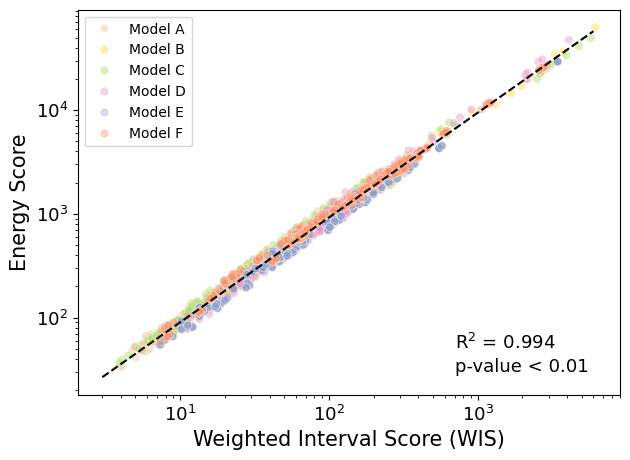

In [369]:
fig, axes = plt.subplots(figsize=(7, 5))
rd = 4
es = pd.read_pickle('../fludat/energyscore_individual_rd4_hosp_521.pkl')

wisdf = pd.read_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt =['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
       'UT-ImmunoSEIRS', 'NIH-Flu_TS']


i=0


    
allscores = es.merge(wisdf, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap')

#plt.plot(allscores.WISnorm, allscores.energyscore,'.',markersize=8, label = model, alpha=.4)

sns.scatterplot(data=allscores, x='WIS', y='energyscore', hue='modelmap', palette='Set2_r', alpha=.4)

    
    
    
#allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


#plt.plot(allscores.WIS, allscores.energyscore,'.',color='teal',markersize=8, label = model, alpha=.4)

slope, intercept, r_value, p_value, std_err = linregress(allscores.WIS, allscores.energyscore)

logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(allscores.WIS), 
                                                                        np.log10(allscores.energyscore),
                                                                       alternative='two-sided')


xval = np.linspace(3, 6000, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(700,50, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.text(700,30, r'p-value < 0.01', fontsize=13)




plt.xlabel('Weighted Interval Score (WIS)', fontsize=15)
plt.ylabel('Energy Score', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#plt.xlim([3, 3800])

plt.xscale("log")
plt.yscale("log")


plt.legend(title=None)

plt.savefig('../figs/ESvsWIS_fromtraj_103.pdf')
plt.show()

In [359]:
p_value

0.0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


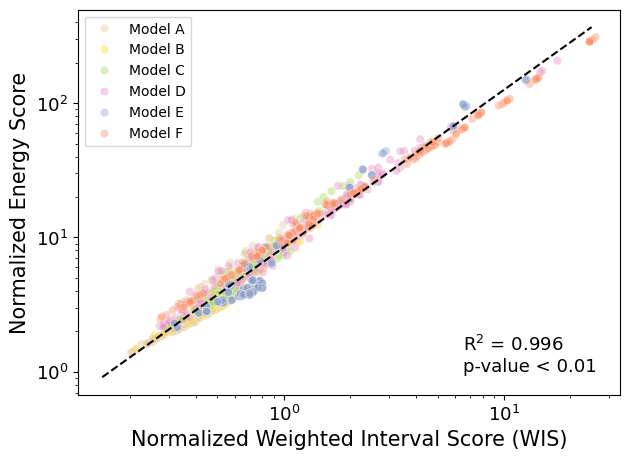

In [19]:
fig, axes = plt.subplots(figsize=(7, 5))
rd = 4
esdf_norm =pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")

wisnormdf = pd.read_pickle('../fludat/wisnorm_obs_individual_rd4.pkl')

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt =['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
       'UT-ImmunoSEIRS', 'NIH-Flu_TS']

i=0

#wis = wisnormdf[wisnormdf.Model == model]

#esmod = esdf_norm[esdf_norm.Model == model]

allscores = esdf_norm.merge(wisnormdf, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap')

#plt.plot(allscores.WISnorm, allscores.energyscore,'.',markersize=8, label = model, alpha=.4)

sns.scatterplot(data=allscores, x='WISnorm', y='energyscore', hue='modelmap', palette='Set2_r', alpha=.4)


slope, intercept, r_value, p_value, std_err = linregress(allscores.WISnorm, allscores.energyscore)

logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(allscores.WISnorm), 
                                                                        np.log10(allscores.energyscore),
                                                                       alternative='two-sided')


xval = np.linspace(.15, 25, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(6.5,1.45, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.text(6.5,1, r'p-value < 0.01', fontsize=13)

    
i+=1
    
plt.xlabel('Normalized Weighted Interval Score (WIS)', fontsize=15)
plt.ylabel('Normalized Energy Score', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#plt.xlim([3, 3800])

plt.xscale("log")
plt.yscale("log")


plt.legend(title=None)

#plt.savefig('../figs/ESvsWIS_norm_fromtraj_102.pdf')
plt.show()

In [348]:
p_value

0.0

In [368]:
r_value

0.9955905997022851

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


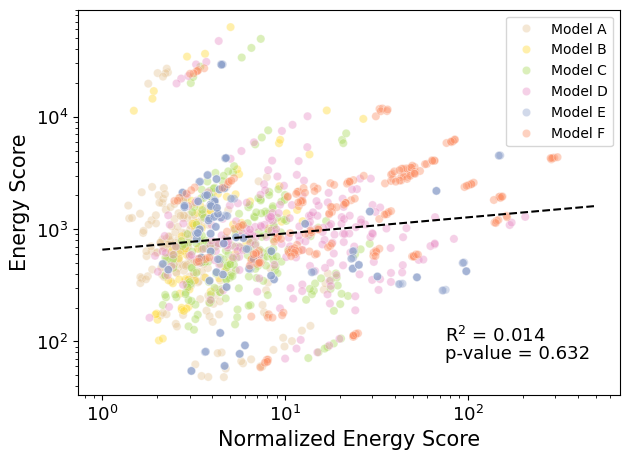

In [445]:
# energy score vs normalized energy score

energyscoresdf_norm =pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")
energyscoresdf_norm = energyscoresdf_norm.rename(columns={'energyscore':'energyscore_norm'})
es = pd.read_pickle('../fludat/energyscore_individual_rd4_hosp_521.pkl')

fig, axes = plt.subplots(figsize=(7, 5))
rd = 4

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt =['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
       'UT-ImmunoSEIRS', 'NIH-Flu_TS']

i=0

#wis = wisnormdf[wisnormdf.Model == model]

#esmod = esdf_norm[esdf_norm.Model == model]

allscores = energyscoresdf_norm.merge(es, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap')

#plt.plot(allscores.WISnorm, allscores.energyscore,'.',markersize=8, label = model, alpha=.4)

sns.scatterplot(data=allscores, x='energyscore_norm', y='energyscore', hue='modelmap', palette='Set2_r', alpha=.4)


slope, intercept, r_value, p_value, std_err = linregress(allscores.energyscore_norm, allscores.energyscore)

logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(allscores.energyscore_norm), 
                                                                        np.log10(allscores.energyscore),
                                                                       alternative='two-sided')


xval = np.linspace(1, 500, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(75,100, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.text(75,70, r'p-value = '+str(round(p_value, 3)), fontsize=13)

    
i+=1
    
plt.xlabel('Normalized Energy Score', fontsize=15)
plt.ylabel('Energy Score', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#plt.xlim([3, 3800])

plt.xscale("log")
plt.yscale("log")


plt.legend(title=None)

plt.savefig('../figs/ESvsESnorm_103.pdf')
plt.show()

In [443]:
p_value

0.6324929518523725

# Energy score vs population size

In [20]:
energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf_norm =pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructio

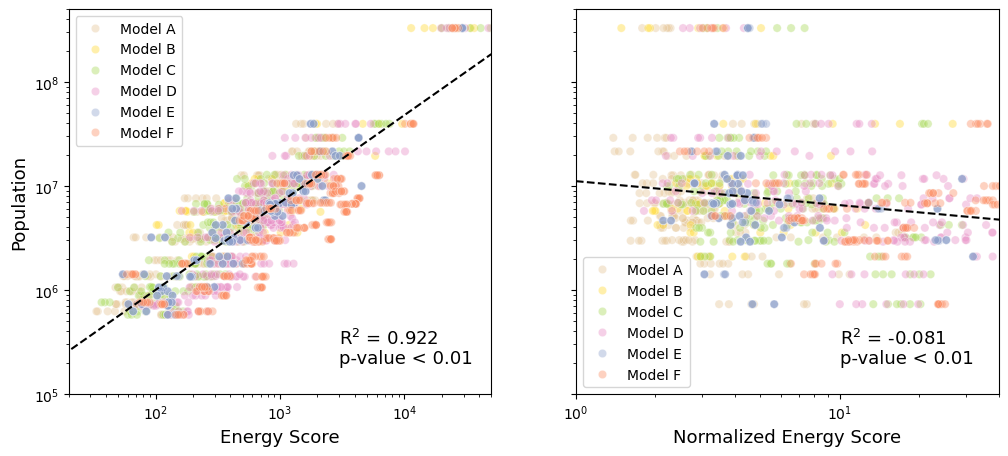

In [27]:
plt.subplots(1,2,figsize=(12,5), sharey= True)


plt.subplot(1,2,1)
#energyscoredf = energyscoresdf[(energyscoresdf.Model == 'MOBS_NEU-GLEAM_FLU') ].dropna()
#energyscoredfnorm = energyscoresdf_norm[(energyscoresdf_norm.Model =='MOBS_NEU-GLEAM_FLU') ].dropna()

energyscoredf = energyscoresdf.dropna()
energyscoredfnorm = energyscoresdf_norm.dropna()

energyscoredf['modelmap'] = energyscoredf['Model'].apply(lambda x: modelmap[x])
energyscoredf = energyscoredf.sort_values(by='modelmap')

energyscoredfnorm['modelmap'] = energyscoredfnorm['Model'].apply(lambda x: modelmap[x])
energyscoredfnorm = energyscoredfnorm.sort_values(by='modelmap')

#plt.loglog(energyscoredf.energyscore, energyscoredf.population, '.', color='teal', alpha=.5)

sns.scatterplot(data=energyscoredf, x='energyscore', y='population', hue='modelmap', palette='Set2_r', alpha=.4)


plt.xlabel('Energy Score', fontsize=13)
plt.ylabel('Population', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredf.energyscore, energyscoredf.population)
    
logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(energyscoredf.energyscore), 
                                                                            np.log10(energyscoredf.population),
                                                                           alternative='two-sided')
    
    
xval = np.linspace(1, 50000, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(3000,300000, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.text(3000,200000, r'p-value < 0.01', fontsize=13)

#plt.text(900,700000, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
print(p_value)

plt.xlim([20, 50000])
plt.ylim([1e5, 5e8])

plt.xscale('log')
plt.yscale('log')
plt.legend(title=None)


plt.subplot(1,2,2)

#plt.loglog(energyscoredfnorm.energyscore, energyscoredfnorm.population, '.', color='coral', alpha=.5)

sns.scatterplot(data=energyscoredfnorm, x='energyscore', y='population', hue='modelmap', palette='Set2_r', alpha=.4)


plt.xlabel('Normalized Energy Score', fontsize=13)
#plt.ylabel('Total number of hospitalizations', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredfnorm.energyscore, energyscoredfnorm.population)
    
logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(energyscoredfnorm.energyscore), 
                                                                            np.log10(energyscoredfnorm.population),
                                                                           alternative='two-sided')
    
    
xval = np.linspace(1, 50000, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(10,300000, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.text(10,200000, r'p-value < 0.01', fontsize=13)

plt.xlim([1, 40])
plt.ylim([1e5, 5e8])

plt.xscale('log')
plt.yscale('log')
print(p_value)
plt.legend(title=None)
    

#plt.savefig('../figs/energyscore_norm_population_allmodels_regress.pdf')

# Compare SMH projections with baseline model

In [28]:
# download baseline model energy score 

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'

# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [14]:
ES_ratiodf

,Model,Label,location,energyscore,target,abbreviation,location_name,population,baseline_model,horizon,energyscore_baseline,ES_ratio
0,MOBS_NEU-GLEAM_FLU,Scenario A,10,63.366537,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.061673
1,MOBS_NEU-GLEAM_FLU,Scenario B,10,73.832873,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.237031
2,MOBS_NEU-GLEAM_FLU,Scenario C,10,51.835970,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,0.868484
3,MOBS_NEU-GLEAM_FLU,Scenario D,10,64.822412,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.086065
4,MOBS_NEU-GLEAM_FLU,Scenario E,10,52.877779,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,0.885939
...,...,...,...,...,...,...,...,...,...,...,...,...
1669,Trajectory Ensemble,Scenario B,US,13995.753687,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,0.647724
1670,Trajectory Ensemble,Scenario C,US,17075.372097,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,0.790249
1671,Trajectory Ensemble,Scenario D,US,13038.828638,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,0.603438
1672,Trajectory Ensemble,Scenario E,US,20797.386801,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,0.962504


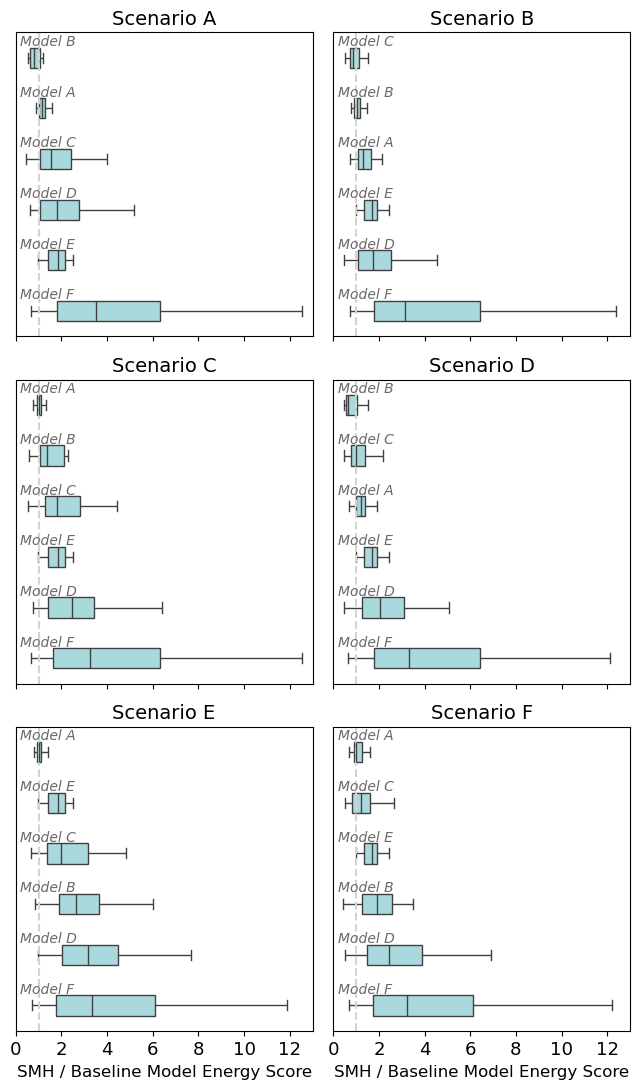

In [29]:
fig, ax = plt.subplots(3,2,figsize=(6.5,11), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in ES_ratiodf.Label.unique():
    plt.subplot(3,2,i)
    
    if i<3:
        x = 0
    elif i<5:
        x=1
    else:
        x=2
        
    if i in [1,3,5]:
        y=0
    else:
        y=1
    
    rankinfo = ES_ratiodf[ES_ratiodf.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["ES_ratio"].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='ES_ratio', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4,
                   showfliers=False)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('SMH / Baseline Model Energy Score', fontsize=12)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    plt.xlim([0, 13])
    
    
    for patch in ax[x][y].patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))

    # plot underlying distribution
   # sns.swarmplot(x='ES_ratio', y='Model', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .35,size=.9,
    #              orient="h")  
    
    plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

    
    a = 0
    for mod in list(my_order):
        plt.text(0.2,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.tight_layout()
#plt.savefig('../figs/ESratio_flurd4_models_826.pdf')
plt.show()


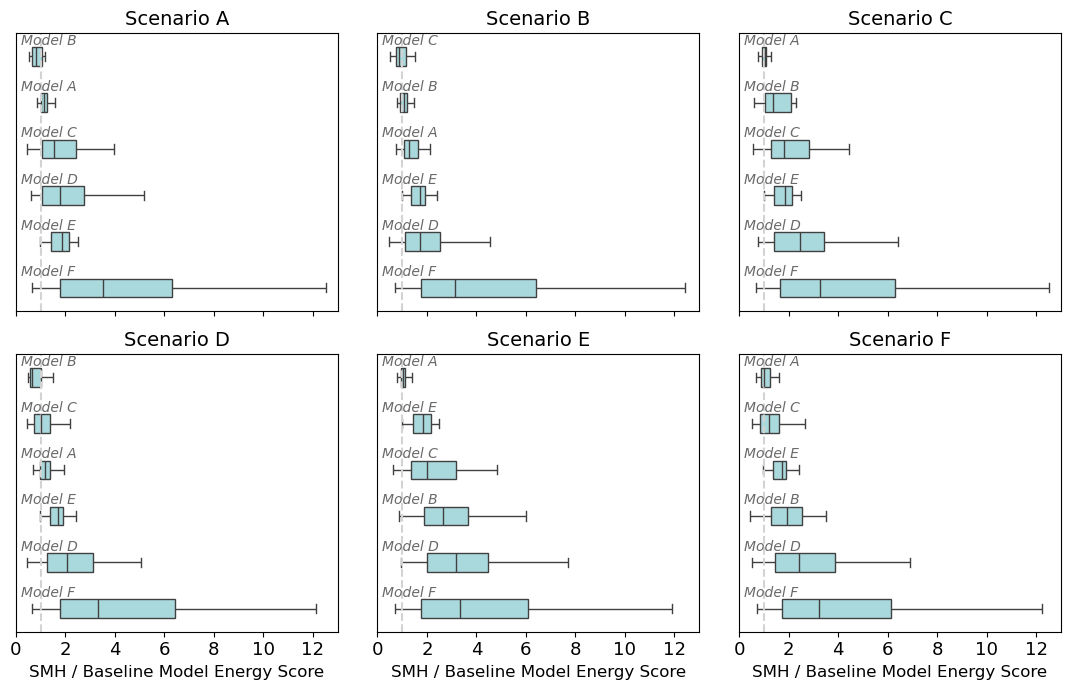

In [436]:
fig, ax = plt.subplots(2,3,figsize=(11,7), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in ES_ratiodf.Label.unique():
    plt.subplot(2,3,i)
    
    if i<4:
        x = 0
    else:
        x=1

        
    if i in [1,4]:
        y=0
    elif i in [2,5]:
        y=1
    else:
        y=2
    
    rankinfo = ES_ratiodf[ES_ratiodf.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["ES_ratio"].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='ES_ratio', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4,
                   showfliers=False)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 4]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [4,5,6]:
        plt.xlabel('SMH / Baseline Model Energy Score', fontsize=12)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    plt.xlim([0, 13])
    
    
    for patch in ax[x][y].patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))

    # plot underlying distribution
   # sns.swarmplot(x='ES_ratio', y='Model', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .35,size=.9,
    #              orient="h")  
    
    plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

    
    a = 0
    for mod in list(my_order):
        plt.text(0.2,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('../figs/ESratio_flurd4_models__h_917.pdf')
plt.show()


# Rankings

In [51]:
# energy score rank

es_all = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")


# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [52]:
# wis rank

dfa =  pd.read_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_521.pkl") 
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

dfa = dfa[~dfa['Model'].isin(singleloc_models)]


dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WIS')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)


dfrankallwis = dfrank.reset_index()
dfrankallwis = dfrankallwis.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_wis'})


In [53]:
dfrankall = dfrankallenergyscore.merge(dfrankallwis, on = ['Model', 'location', 'Label', 'target'])

In [54]:
dfrankall

,Model,location,standard_rank_ES,target,Label,standard_rank_wis
0,MOBS_NEU-GLEAM_FLU,1,1,hosp,Scenario A,1
1,NotreDame-FRED,1,2,hosp,Scenario A,2
2,UT-ImmunoSEIRS,1,3,hosp,Scenario A,3
3,USC-SIkJalpha,1,4,hosp,Scenario A,5
4,PSI-M2,1,5,hosp,Scenario A,4
...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,US,2,hosp,Scenario F,3
1628,NotreDame-FRED,US,3,hosp,Scenario F,4
1629,USC-SIkJalpha,US,4,hosp,Scenario F,5
1630,PSI-M2,US,5,hosp,Scenario F,2


In [55]:
# calculate kendall tau rank correlation for energy score and WIS
ranks = pd.DataFrame()
for loc in dfrankall.location.unique():
    for scenario in dfrankall.Label.unique():

        df = dfrankall[(dfrankall.location==loc) & (dfrankall.Label==scenario)]
        tau, pval = stats.kendalltau(df.standard_rank_wis, df.standard_rank_ES)
        
        row = pd.DataFrame({'location':loc, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranks = pd.concat([ranks, row])

In [56]:
ranks.mean()  

tau    0.870726
dtype: float64

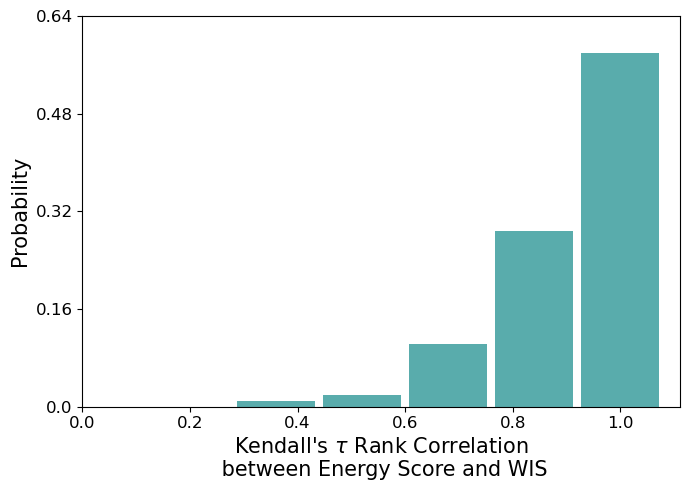

In [100]:
plt.figure(figsize=(7,5))
plt.hist(ranks.tau,bins=5,color='teal', rwidth=.9, alpha=.65, align='right')
plt.xlabel('Kendall\'s'+ r' $\tau$ Rank Correlation'+ '\n between Energy Score and WIS', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks([0, .2, .4, .6, .8, 1.0], fontsize=12)
plt.yticks([0,50,100,150,200],fontsize=12, labels = [round(i/len(ranks),2) for i in [0,50,100,150,200]])
#plt.yticklabel([i/len(ranks) for i in [0,50,100,150,200]],fontsize=12)

plt.tight_layout()
plt.savefig('../figs/kendalltau_histogram_rank_D.pdf')

In [94]:
len(ranks[ranks.tau>.9])/len(ranks)

0.5

rank with normalized scores

In [101]:
energyscoresdf_norm =pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")


In [39]:
energyscoresdf_norm

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,2.796140,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,2.545872,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,3.157534,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,2.542182,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,3.317210,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,3.312413,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,3.608566,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,3.278241,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,3.155635,hosp,US,US,328728466


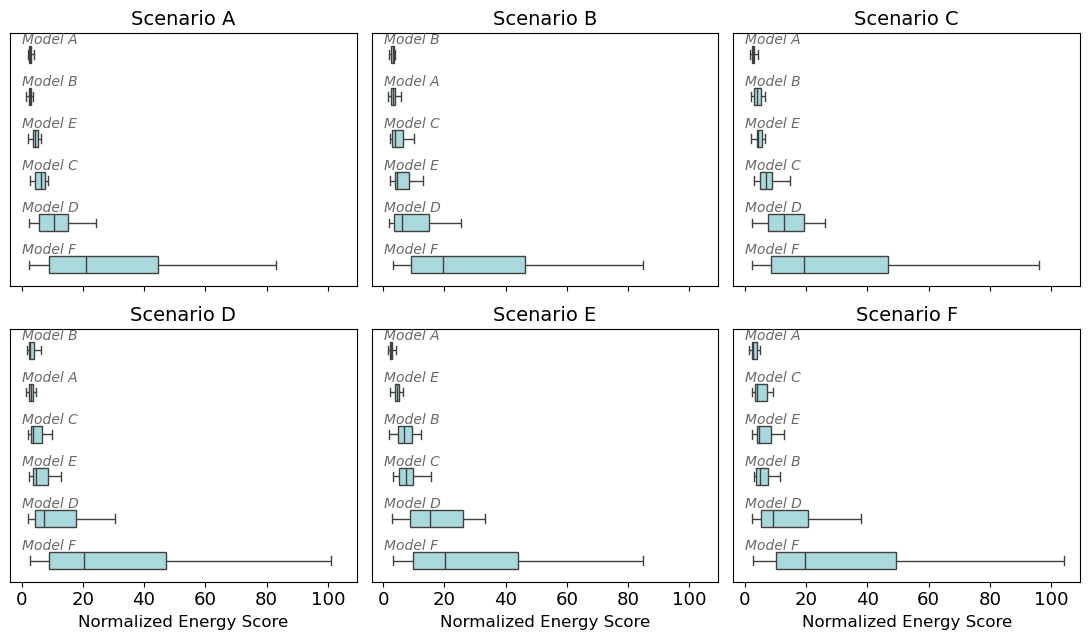

In [492]:

fig, ax = plt.subplots(2,3,figsize=(11,6.5), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in energyscoresdf_norm.Label.unique():
    plt.subplot(2,3,i)
    
    if i<4:
        x = 0
    else:
        x=1
        
    if i in [1,4]:
        y=0
    elif i in [2,5]:
        y=1
    else:
        y=2
    
    rankinfo = energyscoresdf_norm[energyscoresdf_norm.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='energyscore', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4,
                   showfliers=False)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [4,5,6]:
        plt.xlabel('Normalized Energy Score', fontsize=12)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
   # plt.xlim([0, 13])
    
    
    for patch in ax[x][y].patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))

    # plot underlying distribution
   # sns.swarmplot(x='ES_ratio', y='Model', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .35,size=.9,
    #              orient="h")  
    
   # plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

    
    a = 0
    for mod in list(my_order):
        plt.text(0.2,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('../figs/ESnorm_flurd4_models_horizon.pdf')
plt.show()


calculate Kendalls tau rank correlation between energy score and normalized energy score

In [109]:
es_all = pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")


# normalized energy score rank

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscorenorm = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [110]:
# energy score rank

es_all = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")


# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [111]:
dfrankES = dfrankallenergyscorenorm.merge(dfrankallenergyscore, on = ['Model', 'location', 'Label', 'target'])

In [112]:
ranksES = pd.DataFrame()
for loc in dfrankall.location.unique():
    for scenario in dfrankES.Label.unique():

        df = dfrankES[(dfrankES.location==loc) & (dfrankES.Label==scenario)]
        tau, pval = stats.kendalltau(df.standard_rank_ES_x, df.standard_rank_ES_y)
        
        row = pd.DataFrame({'location':loc, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranksES = pd.concat([ranksES, row])

In [113]:
ranksES.mean()

tau    0.563675
dtype: float64

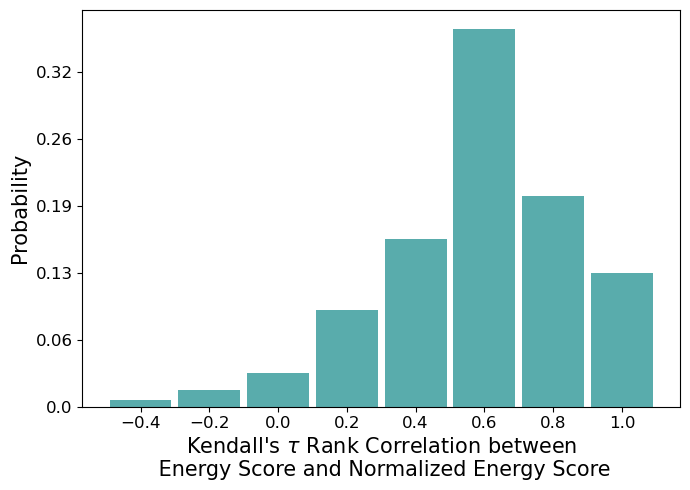

In [118]:
# Normalized energy score vs regular energy score
plt.figure(figsize=(7,5))
plt.hist(ranksES.tau,bins=8,color='teal', rwidth=.9, alpha=.65, align='right')
plt.xlabel('Kendall\'s'+ r' $\tau$ Rank Correlation between'+ '\n Energy Score and Normalized Energy Score', 
           fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks([-.4, -.2,0, .2, .4, .6, .8, 1.0], fontsize=12)
plt.yticks([0,20,40,60,80,100],fontsize=12, labels = [round(i/len(ranksES),2) for i in [0,20,40,60,80,100]])
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('../figs/kendalltau_hist_ES_ESnorm_E.pdf')
plt.show()

In [ ]:
 # compare normalized energy score and normalized WIS divided by observations

In [102]:
es_all = pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_521.pkl")


# normalized energy score rank

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [103]:
# normalized WIS rank
wisnorm = pd.read_pickle('../fludat/wisnorm_obs_individual_rd4.pkl')

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  wisnorm.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WISnorm')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallwisnorm = dfrankall.reset_index()
dfrankallwisnorm = dfrankallwisnorm.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_WIS'})


In [104]:
dfranknorm = dfrankallenergyscore.merge(dfrankallwisnorm, on = ['Model', 'location', 'Label', 'target'])

ranksnorm = pd.DataFrame()
for loc in dfranknorm.location.unique():
    for scenario in dfranknorm.Label.unique():

        df = dfranknorm[(dfranknorm.location==loc) & (dfranknorm.Label==scenario)]
        tau, pval = stats.kendalltau(df.standard_rank_ES, df.standard_rank_WIS)
        
        row = pd.DataFrame({'location':loc, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranksnorm = pd.concat([ranksnorm, row])



In [119]:
ranksnorm.mean()

tau    0.913333
dtype: float64

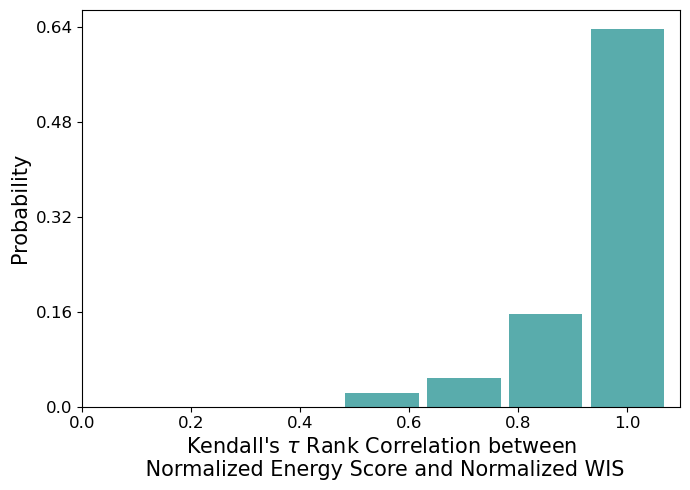

In [121]:
# Normalized energy score vs normalized WIS by observations
plt.figure(figsize=(7,5))
plt.hist(ranksnorm.tau,bins=4,color='teal', rwidth=.9, alpha=.65, align='right')
plt.xlabel('Kendall\'s'+ r' $\tau$ Rank Correlation between'+ '\n Normalized Energy Score and Normalized WIS', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks([0, .2, .4, .6, .8, 1.0], fontsize=12)
plt.yticks([0,50,100,150,200],fontsize=12, labels = [round(i/len(ranksES),2) for i in [0,50,100,150,200]])
plt.tight_layout()

plt.savefig('../figs/kendalltau_hist_norms_ESWISobs_F.pdf')
plt.show()


In [123]:
(len(ranksnorm[ranksnorm.tau>.999])/len(ranksnorm))*100

65.92592592592592

# Map of ES median scores

In [499]:
baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})
baseline = baseline[baseline.location!='US']
baseline['location'] = baseline['location'].astype(int)

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'
energyscoresdf = energyscoresdf[energyscoresdf.location!='US']
energyscoresdf['location'] = energyscoresdf['location'].astype(int)

ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [500]:
df = ES_ratiodf[['Model', 'Label', 'location', 'abbreviation', 'location_name', 'ES_ratio']]
df = df[(df.Label=='Scenario D') & (df.location != 'US')]

In [501]:
df.groupby(by=['location', 'abbreviation', 'location_name']).median().to_csv('../fludat/ESratio_state_median.csv')

In [502]:
df = pd.read_csv('../fludat/ESratio_state_median.csv')

In [503]:
df.head()

,location,abbreviation,location_name,ES_ratio
0,1,AL,Alabama,1.445765
1,2,AK,Alaska,1.875050
2,4,AZ,Arizona,0.903995
3,5,AR,Arkansas,1.561043
4,6,CA,California,2.031629


(-200.0, -50.0)

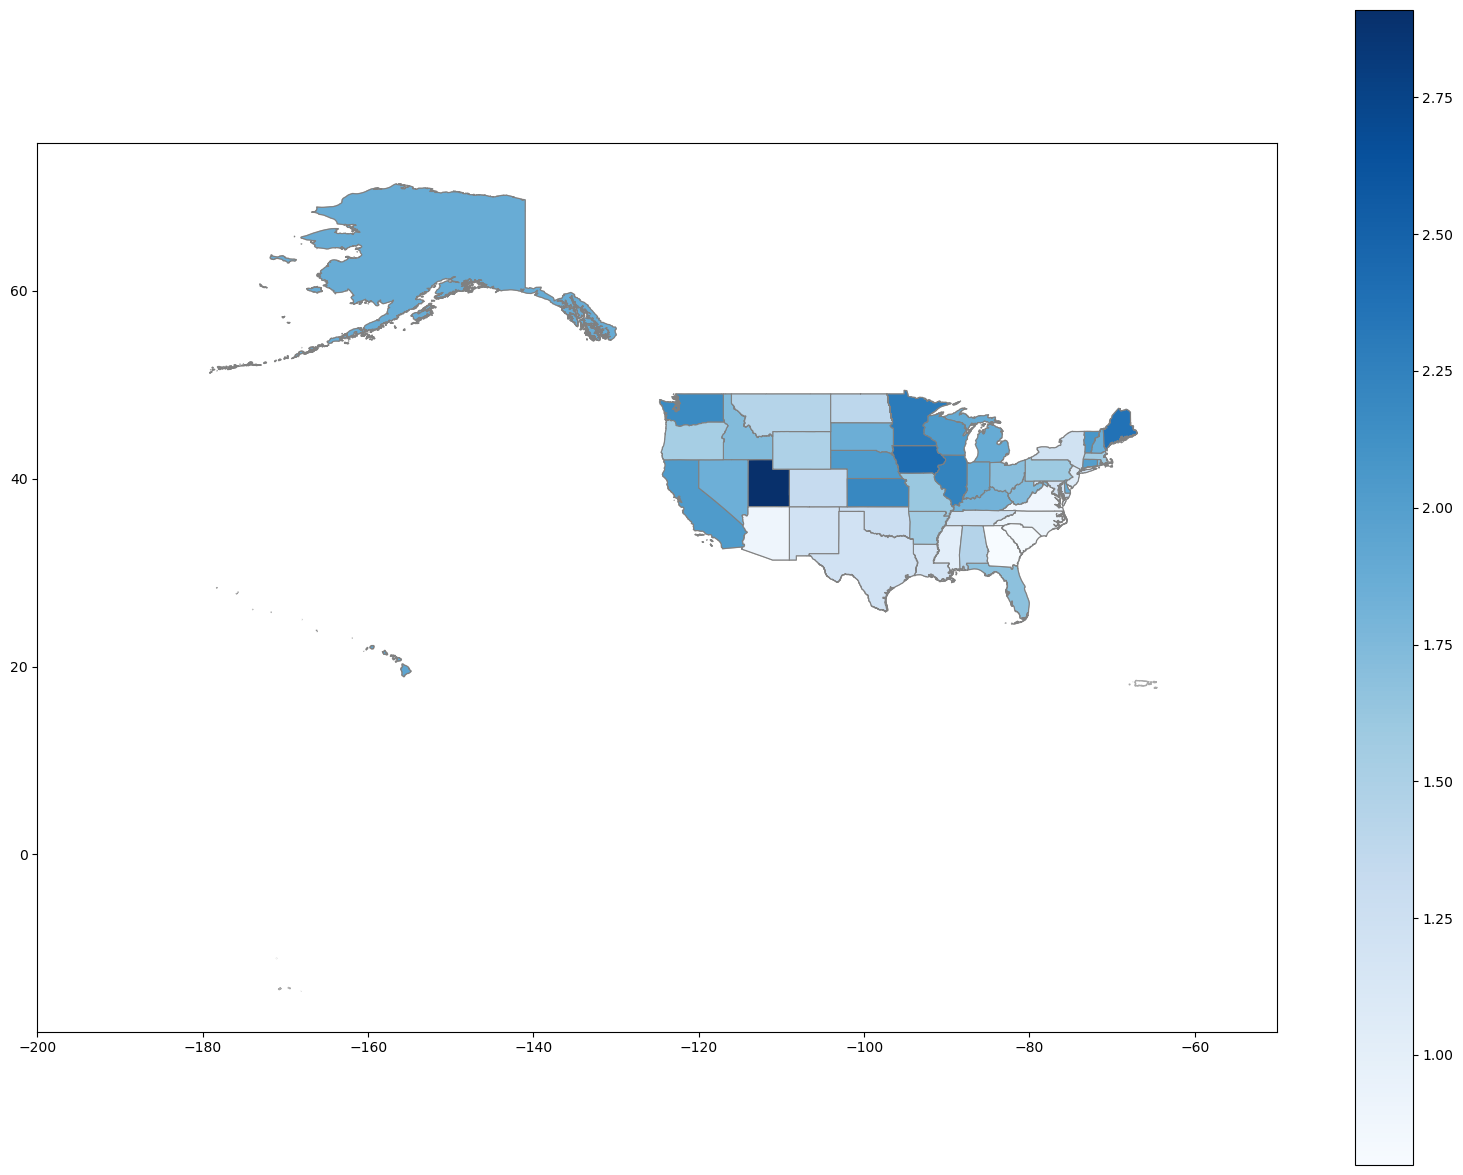

In [507]:
us = gpd.read_file('../cb_2018_us_state_500k')
us = us.rename(columns={'STATEFP':'location'})
us['location'] = us['location'].astype(int)

# Merge datasets
merged = us.merge(df.groupby(by='location').mean(), how='left', left_on='location', right_on='location')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20,15))
us.plot(ax=ax, color='white', edgecolor='darkgray')  # Plot all countries

merged.plot(column='ES_ratio', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='gray', legend=True)
plt.xlim([-200, -50])

#plt.title(f'Mean Number of times in the 7 day period facility reported admissions to adult bed on \n previous calendar day with confirmed COVID-19', fontsize=20)

In [512]:
# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    #norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.PRGn)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

In [509]:
from shapely.geometry import Polygon


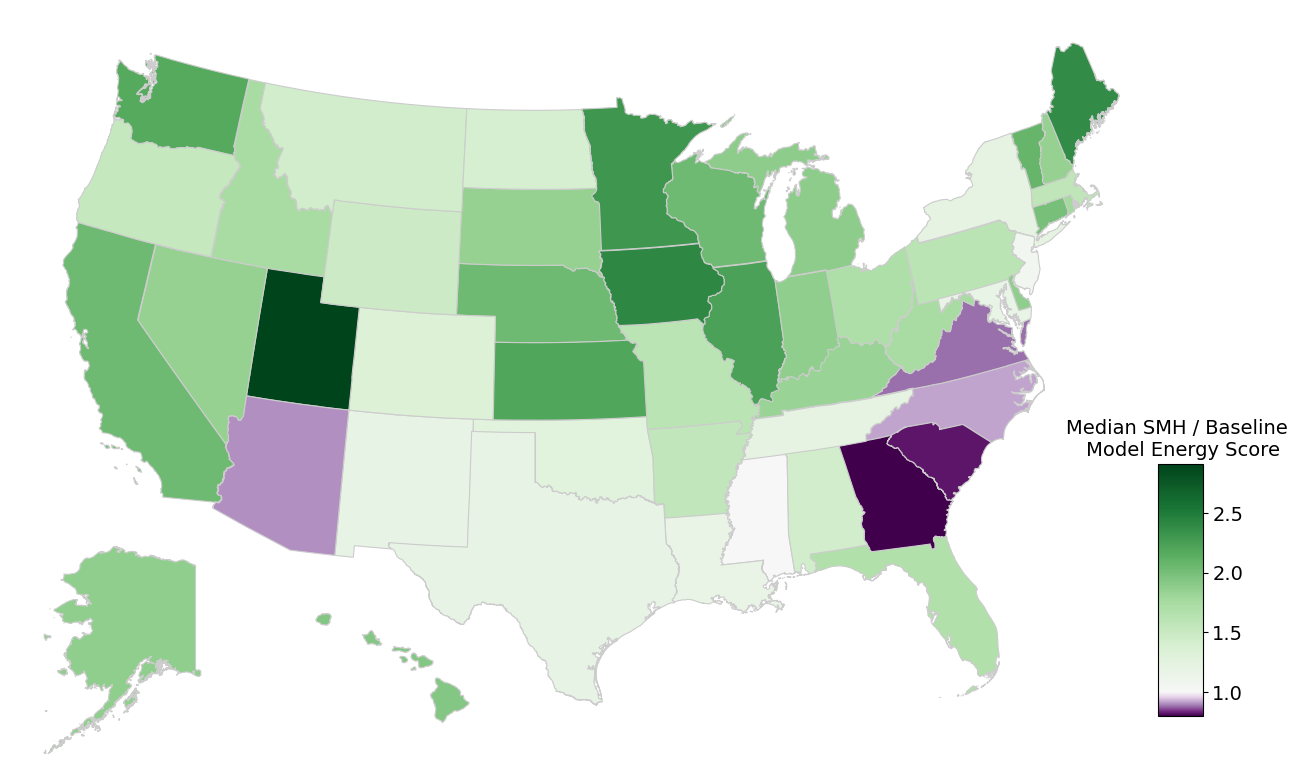

In [514]:
variable = 'ES_ratio'
gdf = merged.copy()

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.ES_ratio.min(), gdf.ES_ratio.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "PRGn"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 12))
# remove the axis box around the vis
ax.axis('off')
#ax.set_xlim([-6,3])

# set the font for the visualization to Helvetica
#hfont = {'fontname':'Helvetica'}

# add a title and annotation
#ax.set_title('Food Insecurity by Percentage of State Households\n2019-2021', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.21])   

cbax.set_title('Median SMH / Baseline \n Model Energy Score', fontdict={'fontsize': '14', 'fontweight' : '0'})

# add color scale
#sm = plt.cm.ScalarMappable(cmap=colormap, \
#                 norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax))


# reformat tick labels on legend
sm._A = []
#comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
#fig.colorbar(sm, cax=cbax, format=comma_fmt)
cbar = fig.colorbar(sm, cax=cbax, spacing='proportional')
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)
cbar.ax.set_yscale('linear')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.location not in [2, 15, 72, 69, 78, 60, 66]:
        vf = visframe[visframe.location==row.location]
        c = gdf[gdf.location==row.location][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.location==2]
alaska_gdf.clip(polygon).plot(color=gdf[gdf.location==2].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.2, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.location==15]
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


fig.savefig('../figs/ESratio_median_map_diverging_108.pdf', bbox_inches="tight")
